# Bug Dataset

In [ ]:
# imports
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

## First reading file data and save it as dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pug_df = pd.read_csv('/content/drive/My Drive/Unified-file.csv')
pug_df

,ID,Name,LongName,Parent,McCC,CLOC,PDA,PUA,LLOC,LOC,bug
0,L123,BaseDiscCache.java,library/src/com/nostra13/universalimageloader/...,L122,3,0,1,4,32,49,0
1,L124,DiscCacheAware.java,library/src/com/nostra13/universalimageloader/...,L122,1,0,4,0,7,29,0
2,L125,LimitedDiscCache.java,library/src/com/nostra13/universalimageloader/...,L122,9,0,3,3,86,133,2
3,L189,FileCountLimitedDiscCache.java,library/src/com/nostra13/universalimageloader/...,L188,1,0,3,0,17,49,0
4,L190,LimitedAgeDiscCache.java,library/src/com/nostra13/universalimageloader/...,L188,5,0,3,2,47,79,1
...,...,...,...,...,...,...,...,...,...,...,...
43739,L613188,UIProblemHandler.java,/org.eclipse.update.ui/src/org/eclipse/update/...,L613162,1,0,2,0,10,30,0
43740,L618459,UpdateManagerUI.java,/org.eclipse.update.ui/src/org/eclipse/update/...,L618458,1,0,3,0,19,50,1
43741,L614656,InstallServlet.java,/org.eclipse.update.ui/src_webapp/org/eclipse/...,L614655,11,0,1,5,155,208,0
43742,L614657,ServletsUtil.java,/org.eclipse.update.ui/src_webapp/org/eclipse/...,L614655,6,0,1,7,123,152,0


### Dataset Description :
<li>This Dataset contains code metrics that describes the predicts whither there is a bug in the code or not</li>
<li>The Dataset contains multiple metrics type for the code like:
    <ul>
        <li>Cohesion metrics: measure to what extent the source code elements are coherent in the system</li>
        <li>Complexity metrics: measure the complexity of source code elements (typically algorithms).</li>
        <li>Coupling metrics: measure the amount of interdependencies of source code elements.</li>
        <li>Documentation metrics: measure the amount of comments and documentation of source code elements in the system.</li>
        <li>Inheritance metrics: measure the different aspects of the inheritance hierarchy of the system.</li>
        <li>Size metrics: measure the basic properties of the analyzed system in terms of different cardinalities (e.g. number of code lines, number of classes or methods).</li>
    </ul>
</li>
<li>Dataset consists of 11 Attruibutes and 43744 instance</li> 
<li>First 10 attruibutes represents one example of each of the code metrics used to predict the bugs and last attributes is the goal value to predict  </li>

# Data Wrangling

**In this section, data wrangling and EDA will be performed to give more insights on the dataset.**

<strong>The list of important attributes are</strong> 
<ol>
  <li>McCC: McCabe’s Cyclomatic Complexity</li>
  <li>CLOC: Comment Lines of Code</li>
  <li>PDA: Public Documented API</li>
  <li>PUA: Public Undocumented API</li>
  <li>LLOC: Logical lines of code</li>
  <li>LOC: Lines of Code</li>
</ol>

<br> Starting off by knowing the types of the data in the dataframe

In [ ]:
pug_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43744 entries, 0 to 43743
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        43744 non-null  object
 1   Name      43744 non-null  object
 2   LongName  43744 non-null  object
 3   Parent    43744 non-null  object
 4   McCC      43744 non-null  int64 
 5   CLOC      43744 non-null  int64 
 6   PDA       43744 non-null  int64 
 7   PUA       43744 non-null  int64 
 8   LLOC      43744 non-null  int64 
 9   LOC       43744 non-null  int64 
 10  bug       43744 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 16.9 MB


In [ ]:
# Reducing the memory load by downcasting the int64 attributes to be int8 or int16
for col in pug_df.columns:
  if pug_df[col].dtype == 'int64':
    pug_df[col] = pd.to_numeric(pug_df[col],downcast='integer')
pug_df.info(memory_usage= 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43744 entries, 0 to 43743
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        43744 non-null  object
 1   Name      43744 non-null  object
 2   LongName  43744 non-null  object
 3   Parent    43744 non-null  object
 4   McCC      43744 non-null  int16 
 5   CLOC      43744 non-null  int8  
 6   PDA       43744 non-null  int16 
 7   PUA       43744 non-null  int16 
 8   LLOC      43744 non-null  int16 
 9   LOC       43744 non-null  int16 
 10  bug       43744 non-null  int8  
dtypes: int16(5), int8(2), object(4)
memory usage: 15.0 MB


**After looking at the dataset data types, there are some non-numerical data which does not impact the prediction, so the colums that contains these data are dropped**

In [ ]:
pug_df.drop(columns=['ID','Name','LongName','Parent','CLOC'],inplace=True)
pug_df.head(10)
# pug_df.drop(columns=['ID','Name','LongName','Component','Path','Parent'],inplace=True)
# pug_df.head(10)

,McCC,PDA,PUA,LLOC,LOC,bug
0,3,1,4,32,49,0
1,1,4,0,7,29,0
2,9,3,3,86,133,2
3,1,3,0,17,49,0
4,5,3,2,47,79,1
5,2,3,0,23,56,0
6,1,3,1,17,40,0
7,1,2,0,4,12,0
8,1,1,1,7,14,0
9,2,1,1,26,38,0


In [ ]:
#Dealing with Duplicate Values
pug_df.drop_duplicates(inplace=True)
pug_df[pug_df.duplicated()]

,McCC,PDA,PUA,LLOC,LOC,bug


## Metrics vs Bugs Analysis
**In this section, a visualisation of the code metrics vs bugs in done to know more about the data.**

### Complexity metrics vs Number of bugs

In [ ]:
# Visualising the influnce of the complexity metric on the bugs
mc_vs_bugs = pug_df.groupby('McCC').sum()
mc_dividens = [mc_vs_bugs.iloc[:62,:].sum(),mc_vs_bugs.iloc[62:125,:].sum(),mc_vs_bugs.iloc[125:186,:].sum(),mc_vs_bugs.iloc[186:248,:].sum(),mc_vs_bugs.iloc[248:310,:].sum(),mc_vs_bugs.iloc[310:,:].sum()]
df = pd.DataFrame(mc_dividens)

ranges = ['0 to 61','62 to 124','125 to 185','186 to 247','248 to 309','310 to 374']

# x = ['McCC']

fig = px.bar(df,x=ranges,y= 'bug',labels={'x':'McCC'},title='The influence of complexity metrics on the number of bugs')
fig.update(layout=dict(title=dict(x=0.5)))
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.show()


**Looking at the barplot above, it is clear that the more the McCC becomes the bugs decreases**

## Documentation Metrics vs bugs

In [ ]:
# Visualising the influnce of the documentation metric on the bugs
pda_vs_bugs = pug_df[pug_df['PDA']> 0].sum()
pua_vs_bug = pug_df[pug_df['PUA']> 0].sum()
x = ['PDA','PUA']
df= pd.DataFrame([pda_vs_bugs,pua_vs_bug])



fig = px.bar(x=x,y=df.bug,labels=  {'x':'Documentation Metrics', 'y':'Number Of Bugs'},title='The influence of documentation metrics on number of bugs')
fig.update(layout=dict(title=dict(x=0.5)))
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.show()


**Looking at the barplot above, gives us the idea that the documented APIs tend to give more bugs than the undocumented APIs**

## Size Metrics vs Bugs

In [ ]:
# Visualising the influnce of the logical lines of code metric on the bugs
lloc_vs_bugs = pug_df.groupby('LLOC').sum()
lloc_dividens = [lloc_vs_bugs.iloc[:207,:].sum(),lloc_vs_bugs.iloc[207:413,:].sum(),lloc_vs_bugs.iloc[413:619,:].sum(),lloc_vs_bugs.iloc[619:825,:].sum(),lloc_vs_bugs.iloc[825:1031,:].sum(),lloc_vs_bugs.iloc[1031:,:].sum()]
df = pd.DataFrame(lloc_dividens)
ranges = ['0 to 206','208 to 412','413 to 618','619 to 824','825 to 1,030','1,031 to 1,236']

fig = px.bar(df,x=ranges,y= 'bug',labels={'x':'LLOC'},title='The influence of logical lines of code number on the number of bugs')
fig.update(layout=dict(title=dict(x=0.5)))
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.show()


In [ ]:
loc_vs_bugs = pug_df.groupby('LOC').sum()
loc_dividens = [loc_vs_bugs.iloc[:278,:].sum(),loc_vs_bugs.iloc[278:555,:].sum(),loc_vs_bugs.iloc[555:832,:].sum(),loc_vs_bugs.iloc[832:1109,:].sum(),loc_vs_bugs.iloc[1109:1386,:].sum(),loc_vs_bugs.iloc[1386:,:].sum()]
df = pd.DataFrame(loc_dividens)
ranges = ['0 to 277','278 to 554','555 to 831','832 to 1,108','1,109 to 1,385','1,386 to 1,662']

fig = px.bar(df,x=ranges,y= 'bug',labels={'x':'LOC'},title='The influence of lines of code number on the number of bugs')
fig.update(layout=dict(title=dict(x=0.5)))
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.show()


**Looking at the two plots above, tells us that the larger the code gets (lines/ logical lines) of code the less bugs it contains**

After creating these plots, now we have an insights about the code and the influence of each metric on the bugs in the code.

## Training the data without handling outliers

Initial Preprocessing & Splitting the initial Dataset to see the performance of the machine learning models on it.

In [ ]:
# standardize the dataset
sc = StandardScaler()
X = sc.fit_transform(pug_df.iloc[:,:-1].values)

In [ ]:
# Train-Test Split
y = pug_df.iloc[:,-1].values
traning_size = int(len(X) * 0.8)
X_train = X[:traning_size]
X_test = X[traning_size:]
y_train = y[:traning_size]
y_test = y[traning_size:]

In [ ]:
stand_pug_df = pd.DataFrame(X)
stand_pug_df['bug'] = y
stand_pug_df.columns = pug_df.columns
stand_pug_df

,McCC,PDA,PUA,LLOC,LOC,bug
0,-0.288483,-0.37157,-0.019226,-0.428952,-0.494130,0
1,-0.325160,0.00640,-0.302659,-0.535319,-0.552876,0
2,-0.178455,-0.11959,-0.090084,-0.199198,-0.247398,2
3,-0.325160,-0.11959,-0.302659,-0.492772,-0.494130,0
4,-0.251807,-0.11959,-0.160942,-0.365131,-0.406011,1
...,...,...,...,...,...,...
35862,-0.325160,-0.24558,-0.302659,-0.522555,-0.549939,0
35863,-0.325160,-0.11959,-0.302659,-0.484263,-0.491193,1
35864,-0.141778,-0.37157,0.051632,0.094377,-0.027100,0
35865,-0.233469,-0.37157,0.193348,-0.041773,-0.191589,0


## Helper Functions

**In this section, helper functions were made to make the model testing much easier through out the project**
<br><br>
<strong>Plot learning curve </strong> helper function takes the model used and the dataset and the type of scoring and plots the learning curve; it is made to automate the process of the plotting

In [ ]:
def plot_learning_curve (estimator,X,y,cv,scoring ='neg_mean_squared_error',n_jobs=-1):
    from sklearn.model_selection import learning_curve
    import plotly.graph_objects as go
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=cv,
                                                        # Evaluation metric
                                                        scoring=scoring)
                                                    

    train_scores = abs(train_scores) ** (1/2)       
    test_scores = abs(test_scores) ** (1/2)                                       
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)


    fig = go.Figure()
    # Draw lines
    fig.add_trace(go.Scatter(x= train_sizes, y= train_mean,mode='lines',name="Training score"))
    fig.add_trace(go.Scatter(x = train_sizes, y= test_mean,mode='lines',name="Cross-validation score"))

    # Create plot
    fig.update_layout(title = 'Learning Curve',xaxis_title= 'Training Set Size',yaxis_title='RMSE Score')
    return fig

<strong>Build Model</strong> helper function takes a dictionary of the model with its desired parameters and the data it should operate on; then the function trains, predicts, calls plot learning curve function, and creates a dataframe to add the experiment results in for further comparison.

In [ ]:
def build_model(modelsDict,X_train,X_test,y_train,y_test):
  score = {'model_name':[],'kernel':[],'degree':[],'C':[],'n_estimators':[],'criterion':[],'max_depth':[],'RMSE':[] }
  learning_curve_figs = []
  x = np.concatenate((X_train,X_test),axis=0)
  y = np.concatenate((y_train,y_test),axis=0)
  for modelName, params in modelsDict.items():
    if modelName.lower() == 'svm':
      model = SVR()
      for i in range(len(list(params.values())[0])):
        score['model_name'].append(modelName)
        for param,values in params.items():
            if param.lower() == 'kernel':
              score['kernel'].append(values[i])
              score['n_estimators'].append(np.nan)

              model.set_params(kernel = values[i])
            elif param.lower() == 'degree':
              score['degree'].append(values[i])
              score['criterion'].append(np.nan)

              model.set_params(degree=values[i])
            elif param.lower() == 'c':
              score['C'].append(values[i])
              score['max_depth'].append(np.nan)

              model.set_params(C = values[i])

        fig = plot_learning_curve(model,x,y,2)
        learning_curve_figs.append(fig)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred,squared = False)
        score['RMSE'].append(rmse)



      
    if modelName.lower() == 'rf':
      model = RandomForestRegressor(n_jobs=-1)
      for i in range(len(list(params.values())[0])):
        score['model_name'].append(modelName)
        for param,values in params.items():
            if param.lower() == 'n_estimators':
              score['n_estimators'].append(values[i])
              score['kernel'].append(np.nan)
              model.set_params(n_estimators = values[i])
            elif param.lower() == 'criterion':
              score['criterion'].append(values[i])
              score['degree'].append(np.nan)
              model.set_params(criterion=values[i])
            elif param.lower() == 'max_depth':
              score['max_depth'].append(values[i])
              score['C'].append(np.nan)

              model.set_params(max_depth = values[i])
        fig = plot_learning_curve(model,x,y,5)
        learning_curve_figs.append(fig)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred,squared = False)
        score['RMSE'].append(rmse)   


  
  return pd.DataFrame(score),learning_curve_figs

### Initial experiment of the machine learning models on the data

**Here we try different machine learning on the dataset using the created helper functions to see the performance of the model before dealing with outliers.**

In [ ]:
# Executing the Build Model helper function
model = {
    'svm':{
    'kernel':['rbf'],
    'degree':[1],
    'C':[1]
    },
    'rf':{
    'n_estimators':[8],
    'criterion':['mse'],
    'max_depth':[None]
    },
}

scores_Df , learning_curves = build_model(model,X_train,X_test,y_train,y_test)

In [ ]:
# The Output dataframe of the helper function Build model
scores_Df

,model_name,kernel,degree,C,n_estimators,criterion,max_depth,RMSE
0,svm,rbf,1.0,1.0,NaN,NaN,NaN,2.212742
1,rf,NaN,NaN,NaN,8.0,mse,NaN,2.192301


In [ ]:
# plotting the learning curves of the created models
for i in learning_curves:
  i.show()

**As shown in the learning curves above that the Random Forest performed slightly better than the support vector machine, but both are having overfitting in the validation dataset.**

## Removing Outliers
**In this section, different methods were used to deal with outliers including clustering  technique, and isolate forest technique; the methods were compared to see which handeled the outliers in a better way.**

### Using clustring technique

<strong>DBSCAN</strong> Clustring method was used to deal with outliers.

In [ ]:
model = DBSCAN(eps = 3,metric = 'manhattan',n_jobs=-1).fit(X)
outliers = stand_pug_df[model.labels_ == -1]
cluster = stand_pug_df[model.labels_ != -1]
print("The number of outliers that has been removed ", outliers.shape[0],"which is: ", "{:.2f}".format(outliers.shape[0]/ X.shape[0] *100), "%")
print("The number of data without outliers ",cluster.shape[0],"which is: ", "{:.2f}".format(cluster.shape[0]/ X.shape[0] *100),"%")

The number of outliers that has been removed  159 which is:  0.44 %
The number of data without outliers  35708 which is:  99.56 %


In [ ]:
# Splitting the new outlier free Data
t_z = int(len(cluster) * 0.8)
X_clutser_train = cluster.iloc[:t_z,:-1].values
X_clutser_test= cluster.iloc[t_z:,:-1].values
y_cluster_train = cluster.iloc[:t_z,-1].values
y_cluster_test = cluster.iloc[t_z:,-1].values

Testing the models on the newly produced dataset from the clustring (after outlier removal)

In [ ]:
model = {
    'svm':{
    'kernel':['rbf'],
    'degree':[1],
    'C':[1]
    },
    'rf':{
    'n_estimators':[10],
    'criterion':['mse'],
    'max_depth':[10]
    },
}

scores_df,learning_curves = build_model(model,X_clutser_train,X_clutser_test,y_cluster_train,y_cluster_test)

In [ ]:
scores_df

,model_name,kernel,degree,C,n_estimators,criterion,max_depth,RMSE
0,svm,rbf,1.0,1.0,NaN,NaN,NaN,2.032633
1,rf,NaN,NaN,NaN,10.0,mse,10.0,1.925339


In [ ]:
for i in learning_curves:
  i.show()

**After looking at the learning curves, we see a slight improvement in the RMSE score of both models, but the overfitting is still there.**

### Using Isolate Forest

In [ ]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.004,n_jobs=-1)
yhat = iso.fit_predict(X)
outliers = stand_pug_df[yhat == -1]
choosenPoints = stand_pug_df[yhat != -1]
mask = yhat!= -1
X_iso, y_iso = X[mask, :], y[mask]
traning_size = int(len(X_iso) * 0.8)
X_iso_train = X_iso[:traning_size]
X_iso_test = X_iso[traning_size:]
y_iso_train = y_iso[:traning_size]
y_iso_test = y_iso[traning_size:]
print("The number of outliers that has been removed ", outliers.shape[0],"which is: ", "{:.2f}".format(outliers.shape[0]/ X.shape[0] *100), "%")
print("The number of data without outliers ", choosenPoints.shape[0],choosenPoints.shape[0],"which is: ", "{:.2f}".format(choosenPoints.shape[0]/ X.shape[0] *100),"%")

The number of outliers that has been removed  144 which is:  0.40 %
The number of data without outliers  35723 35723 which is:  99.60 %


In [ ]:
model = {
    'svm':{
    'kernel':['rbf'],
    'degree':[1],
    'C':[1]
    },
    'rf':{
    'n_estimators':[10],
    'criterion':['mse'],
    'max_depth':[10]
    },
}

scores_df,learning_curves = build_model(model,X_iso_train,X_iso_test,y_iso_train,y_iso_test)

In [ ]:
scores_df

,model_name,kernel,degree,C,n_estimators,criterion,max_depth,RMSE
0,svm,rbf,1.0,1.0,NaN,NaN,NaN,1.986866
1,rf,NaN,NaN,NaN,10.0,mse,10.0,1.869942


In [ ]:
for i in learning_curves:
  i.show()

**Looking at the learning curves of the data produced from isolate forest technique, we can see that the models scored the same RMSE score as in the dataset produced using the clustring technique.**

## Dimensionality Reduction using PCA

**In this section, we use PCA to reduce the dimensionality of the data to enhance the performance of the models.**

<br>First we test the PCA using different number of components to see the impact of the PCA.

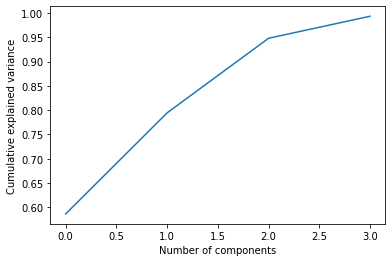

In [ ]:
pca = PCA(n_components=4)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_),)
plt.xlabel('Number of components');
plt.ylabel('Cumulative explained variance');

**After testing we can see a noticable difference in the variance at n_components = 2 is very high which means that it is enough to use only 2 feautres.**

In [ ]:
# Impleminting PCA with number of components = 2
pca = PCA(n_components=2)
X_pca= pca.fit_transform(X)
print('The dimension of the data set before using pca:',X.shape,'after using pca',X_pca.shape)

The dimension of the data set before using pca: (35867, 5) after using pca (35867, 2)


In [ ]:
# Creating the new dataset with the 2 selected features
pca_df = pd.DataFrame(X_pca)
pca_df['bug'] = y
pca_df.columns = ['PC1','PC2','bug']

In [ ]:
px.scatter(pca_df,x = pca_df['PC1'],y = pca_df['bug'])

In [ ]:
px.scatter(pca_df,x = pca_df['PC2'],y = pca_df['bug'])

Looking at the scatter plots of the new dataset features above, we see that there is some outliers that needs to be dealed with, so DBSCAN clustring technique will be used to remove these outliers
<br><br>
**Now we try the models on the new dataset created after applying the PCA to see the performance and the impact of the PCA on the dataset.**

In [ ]:
model = DBSCAN(eps = 2,metric = 'euclidean').fit(X_pca)
outliers = pca_df[model.labels_ == -1]
cluster = pca_df[model.labels_ != -1]
print("The number of outliers that has been removed ", outliers.shape[0],"which is: ", "{:.2f}".format(outliers.shape[0]/ X.shape[0] *100), "%")
print("The number of data without outliers ", cluster.shape[0],cluster.shape[0],"which is: ", "{:.2f}".format(cluster.shape[0]/ X.shape[0] *100),"%")

In [ ]:
cluster['outliers'] = 0
outliers['outliers'] = 1
cluster = cluster.append(outliers)

In [ ]:
px.scatter(cluster,x = cluster['PC1'],y = cluster['bug'],labels={'x': 'PC1','y':'y'},color= cluster['outliers'])


In [ ]:
px.scatter(cluster,x = cluster['PC2'],y = cluster['bug'],labels={'x': 'PC2','y':'y'},color= cluster['outliers'])

**Looking at the new scatter plots we see that the yellow dots that represents the outliers and the blue dots that represents the non-outlier data**
<br><br>
Now we drop the outliers and train the models on the new dataset created with the PCA and outlier removal clustring technique and comparing results with the previous experiments (without PCA).

In [ ]:
no_outlier_df = cluster[cluster['outliers'] == 0]
no_outlier_df.drop(labels='outliers',axis =1 ,inplace = True)
no_outlier_df = no_outlier_df.sample(frac=1)
train_size = len(no_outlier_df) * 0.8
X_train_cluster = no_outlier_df.iloc[:traning_size,:-1].values
X_test_cluster = no_outlier_df.iloc[traning_size:,:-1].values

y_train_cluster = no_outlier_df.iloc[:traning_size,-1].values
y_test_cluster = no_outlier_df.iloc[traning_size:,-1].values


In [ ]:
model = {
    'svm':{
    'kernel':['rbf'],
    'degree':[1],
    'C':[1]
    },
    'rf':{
    'n_estimators':[10],
    'criterion':['mse'],
    'max_depth':[10]
    },
    'svm':{
    'kernel':['linear'],
    'degree':[1],
    'C':[1]
    }
}
scores_df,learning_curves = build_model(model,X_train_cluster,X_test_cluster,y_train_cluster,y_test_cluster) 

In [ ]:
scores_df

In [ ]:
for i in learning_curves:
  i.show()

**After looking at the new scores dataframe and the learning curves, we can notice an improvement in the performance of the models after comparing it with the scores dataframe of the models on the dataset without PCA. Also, the overfitting problem is reduced in the new dataset**

## Ensembled Models

**Here we create an ensmbled model to compare its performance with the other individual models.**

In [ ]:
# Building the ensmble model
from sklearn.neighbors import KNeighborsRegressor
svm = SVR()
rf = RandomForestRegressor(n_estimators=10)
vt = VotingRegressor(estimators=[('svm',svm),('rf',rf)],n_jobs=-1)

In [ ]:
vt.fit(X_train_cluster,y_train_cluster)

In [ ]:
y_pred = vt.predict(X_test_cluster)


In [ ]:
rmse = mean_squared_error(y_test_cluster,y_pred,squared = False)
rmse

In [ ]:
fig = plot_learning_curve(vt,no_outlier_df.iloc[:,:-1],no_outlier_df.iloc[:,-1],3)

In [ ]:
fig

**Looking at the result of the ensmble model and comparing it to the individual models, we can see that the Random Forest still the best model among the three created models with RMSE = 1.577**

# Dataset 2

In [ ]:
pug_df = pd.read_csv('/content/drive/My Drive/Unified-class.csv')
pug_df

,ID,Type,Name,LongName,Parent,Component,Path,Line,Column,EndLine,EndColumn,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,LCOM5,NL,NLE,WMC,CBO,CBOI,NII,NOI,RFC,AD,CD,CLOC,DLOC,PDA,PUA,TCD,TCLOC,DIT,NOA,NOC,NOD,NOP,LLOC,LOC,NA,NG,NLA,NLG,NLM,NLPA,NLPM,NLS,NM,NOS,NPA,NPM,NS,TLLOC,TLOC,TNA,TNG,TNLA,TNLG,TNLM,TNLPA,TNLPM,TNLS,TNM,TNOS,TNPA,TNPM,TNS,bug
0,L70222,Class,BindingKey,org.eclipse.jdt.core.BindingKey,L92879,L103,org.eclipse.jdt.core/model/org/eclipse/jdt/cor...,25,1,267,2,0.0,0,0,0,0.0,0.0,0,0,6,1,1,18,4,8,12,7,20,1.00,0.666667,160,153,14,0,0.666667,160,0,0,0,0,0,80,243,1,2,1,2,13,0,13,0,13,49,0,13,0,80,243,1,2,1,2,13,0,13,0,13,49,0,13,0,0
1,L57358,Class,BufferChangedEvent,org.eclipse.jdt.core.BufferChangedEvent,L92879,L103,org.eclipse.jdt.core/model/org/eclipse/jdt/cor...,47,1,117,2,0.0,0,0,0,0.0,0.0,0,0,0,0,0,5,1,3,5,0,5,1.00,0.757576,75,74,6,0,0.757576,75,0,0,0,0,0,24,71,4,4,4,4,5,0,5,0,5,8,0,5,0,24,71,4,4,4,4,5,0,5,0,5,8,0,5,0,0
2,L117505,Class,CheckDebugAttributes,org.eclipse.jdt.core.CheckDebugAttributes,L92879,L103,org.eclipse.jdt.core/antadapter/org/eclipse/jd...,40,1,98,2,0.0,0,0,0,0.0,0.0,0,0,1,4,4,16,6,0,0,7,11,0.25,0.260274,19,14,1,3,0.260274,19,0,0,0,0,0,54,59,2,0,2,0,4,0,3,2,4,33,0,3,2,54,59,2,0,2,0,4,0,3,2,4,33,0,3,2,0
3,L66611,Class,ClasspathContainerInitializer,org.eclipse.jdt.core.ClasspathContainerInitial...,L92879,L103,org.eclipse.jdt.core/model/org/eclipse/jdt/cor...,44,1,366,2,0.0,0,0,0,0.0,0.0,0,0,2,1,1,14,3,5,3,1,11,1.00,0.851133,263,257,11,0,0.811728,263,0,0,2,2,0,46,308,2,6,2,6,10,2,10,0,10,16,2,10,0,61,323,5,10,2,10,15,2,15,0,15,21,5,15,0,0
4,L130930,Class,ClasspathVariableInitializer,org.eclipse.jdt.core.ClasspathVariableInitializer,L92879,L103,org.eclipse.jdt.core/model/org/eclipse/jdt/cor...,26,1,52,2,0.0,0,0,0,0.0,0.0,0,0,0,0,0,2,0,1,1,0,2,1.00,0.864865,32,31,3,0,0.864865,32,0,0,0,0,0,5,27,0,0,0,0,2,0,2,0,2,0,0,2,0,5,27,0,0,0,0,2,0,2,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47613,L1723,Class,ParserAdapter,org.xml.sax.helpers.ParserAdapter,L45334,L103,src/org/xml/sax/helpers/ParserAdapter.java,55,1,1006,2,0.0,0,0,0,0.0,0.0,0,0,1,3,3,83,18,6,5,44,73,1.00,0.478708,326,305,25,0,0.505882,430,1,2,0,0,2,355,769,19,6,19,6,29,0,24,7,29,156,0,24,7,420,952,20,18,20,18,43,0,36,8,43,175,0,36,8,0
47614,L46023,Class,ParserFactory,org.xml.sax.helpers.ParserFactory,L45334,L103,src/org/xml/sax/helpers/ParserFactory.java,49,1,128,2,0.0,0,0,0,0.0,0.0,0,0,1,1,1,4,2,6,6,2,5,1.00,0.733333,77,77,3,0,0.733333,77,0,0,0,0,0,28,80,0,0,0,0,3,0,2,0,3,5,0,2,0,28,80,0,0,0,0,3,0,2,0,3,5,0,2,0,1
47615,L46032,Class,XMLFilterImpl,org.xml.sax.helpers.XMLFilterImpl,L45334,L103,src/org/xml/sax/helpers/XMLFilterImpl.java,52,1,767,2,0.0,0,0,0,0.0,0.0,0,0,5,1,1,63,13,0,0,28,64,1.00,0.597201,384,383,36,0,0.597201,384,2,6,0,0,5,259,716,6,7,6,7,36,0,35,8,36,80,0,35,8,259,716,6,7,6,7,36,0,35,8,36,80,0,35,8,0
47616,L46198,Class,XMLReaderAdapter,org.xml.sax.helpers.XMLReaderAdapter,L45334,L103,src/org/xml/sax/helpers/XMLReaderAdapter.java,51,1,524,2,0.0,0,0,0,0.0,0.0,0,0,4,1,1,24,14,0,0,19,41,1.00,0.650888,220,218,21,0,0.635714,267,1,2,0,0,2,118,383,3,0,3,0,22,0,20,6,22,27,0,20,6,153,474,4,6,4,6,30,0,26,7,30,34,0,26,7,0


In [ ]:
pug_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47618 entries, 0 to 47617
Data columns (total 72 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         47618 non-null  object 
 1   Type       47618 non-null  object 
 2   Name       47618 non-null  object 
 3   LongName   47618 non-null  object 
 4   Parent     47618 non-null  object 
 5   Component  47618 non-null  object 
 6   Path       47618 non-null  object 
 7   Line       47618 non-null  int64  
 8   Column     47618 non-null  int64  
 9   EndLine    47618 non-null  int64  
 10  EndColumn  47618 non-null  int64  
 11  CC         47618 non-null  float64
 12  CCL        47618 non-null  int64  
 13  CCO        47618 non-null  int64  
 14  CI         47618 non-null  int64  
 15  CLC        47618 non-null  float64
 16  CLLC       47618 non-null  float64
 17  LDC        47618 non-null  int64  
 18  LLDC       47618 non-null  int64  
 19  LCOM5      47618 non-null  int64  
 20  NL    

In [ ]:
for col in pug_df.columns:
  if pug_df[col].dtype == 'int64':
    pug_df[col] = pd.to_numeric(pug_df[col],downcast='integer')
  elif pug_df[col].dtype == 'float64':
    pug_df[col] = pd.to_numeric(pug_df[col],downcast='float')
pug_df.info(memory_usage= 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47618 entries, 0 to 47617
Data columns (total 72 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         47618 non-null  object 
 1   Type       47618 non-null  object 
 2   Name       47618 non-null  object 
 3   LongName   47618 non-null  object 
 4   Parent     47618 non-null  object 
 5   Component  47618 non-null  object 
 6   Path       47618 non-null  object 
 7   Line       47618 non-null  int16  
 8   Column     47618 non-null  int16  
 9   EndLine    47618 non-null  int16  
 10  EndColumn  47618 non-null  int16  
 11  CC         47618 non-null  float32
 12  CCL        47618 non-null  int16  
 13  CCO        47618 non-null  int16  
 14  CI         47618 non-null  int16  
 15  CLC        47618 non-null  float32
 16  CLLC       47618 non-null  float32
 17  LDC        47618 non-null  int16  
 18  LLDC       47618 non-null  int16  
 19  LCOM5      47618 non-null  int16  
 20  NL    

In [ ]:
pug_df.drop(columns=['ID','Name','LongName','Component','Path','Parent'],inplace=True)
pug_df.head(10)

,Type,Line,Column,EndLine,EndColumn,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,LCOM5,NL,NLE,WMC,CBO,CBOI,NII,NOI,RFC,AD,CD,CLOC,DLOC,PDA,PUA,TCD,TCLOC,DIT,NOA,NOC,NOD,NOP,LLOC,LOC,NA,NG,NLA,NLG,NLM,NLPA,NLPM,NLS,NM,NOS,NPA,NPM,NS,TLLOC,TLOC,TNA,TNG,TNLA,TNLG,TNLM,TNLPA,TNLPM,TNLS,TNM,TNOS,TNPA,TNPM,TNS,bug
0,Class,25,1,267,2,0.000000,0,0,0,0.000000,0.000000,0,0,6,1,1,18,4,8,12,7,20,1.0000,0.666667,160,153,14,0,0.666667,160,0,0,0,0,0,80,243,1,2,1,2,13,0,13,0,13,49,0,13,0,80,243,1,2,1,2,13,0,13,0,13,49,0,13,0,0
1,Class,47,1,117,2,0.000000,0,0,0,0.000000,0.000000,0,0,0,0,0,5,1,3,5,0,5,1.0000,0.757576,75,74,6,0,0.757576,75,0,0,0,0,0,24,71,4,4,4,4,5,0,5,0,5,8,0,5,0,24,71,4,4,4,4,5,0,5,0,5,8,0,5,0,0
2,Class,40,1,98,2,0.000000,0,0,0,0.000000,0.000000,0,0,1,4,4,16,6,0,0,7,11,0.2500,0.260274,19,14,1,3,0.260274,19,0,0,0,0,0,54,59,2,0,2,0,4,0,3,2,4,33,0,3,2,54,59,2,0,2,0,4,0,3,2,4,33,0,3,2,0
3,Class,44,1,366,2,0.000000,0,0,0,0.000000,0.000000,0,0,2,1,1,14,3,5,3,1,11,1.0000,0.851133,263,257,11,0,0.811728,263,0,0,2,2,0,46,308,2,6,2,6,10,2,10,0,10,16,2,10,0,61,323,5,10,2,10,15,2,15,0,15,21,5,15,0,0
4,Class,26,1,52,2,0.000000,0,0,0,0.000000,0.000000,0,0,0,0,0,2,0,1,1,0,2,1.0000,0.864865,32,31,3,0,0.864865,32,0,0,0,0,0,5,27,0,0,0,0,2,0,2,0,2,0,0,2,0,5,27,0,0,0,0,2,0,2,0,2,0,0,2,0,0
5,Class,25,1,403,2,0.206642,1,6,2,0.058047,0.170940,22,20,3,3,3,31,4,3,2,2,17,0.9375,0.684636,254,240,15,1,0.684636,254,1,1,0,0,1,117,379,16,10,5,10,15,5,15,0,26,80,5,15,11,117,379,16,10,5,10,15,5,15,0,26,80,5,15,11,1
6,Class,24,1,51,2,0.000000,0,0,0,0.000000,0.000000,0,0,1,0,0,2,0,1,0,0,2,1.0000,0.750000,27,26,2,0,0.750000,27,0,0,0,0,0,9,28,2,0,2,0,2,2,1,0,2,1,2,1,0,9,28,2,0,2,0,2,2,1,0,2,1,2,1,0,0
7,Class,53,1,2278,2,0.260052,17,286,30,0.045822,0.259067,102,100,1,5,5,104,3,10,40,6,46,0.9750,0.824864,1818,1775,39,1,0.824864,1818,1,1,0,0,1,386,2226,70,26,49,20,40,25,39,15,57,190,25,40,24,386,2226,70,26,49,20,40,25,39,15,57,190,25,40,24,1
8,Class,54,1,358,2,0.000000,0,0,0,0.000000,0.000000,0,0,7,1,1,32,3,20,63,0,15,1.0000,0.751534,245,235,16,0,0.751534,245,0,0,4,4,0,81,305,4,1,4,1,15,0,15,4,15,30,0,15,4,81,305,4,1,4,1,15,0,15,4,15,30,0,15,4,0
9,Class,25,1,221,2,0.000000,0,0,0,0.000000,0.000000,0,0,14,0,0,14,2,0,0,0,14,1.0000,0.341969,66,52,15,0,0.341969,66,1,1,0,0,1,127,197,0,0,0,0,14,0,14,0,14,0,0,14,0,127,197,0,0,0,0,14,0,14,0,14,0,0,14,0,0


In [ ]:
pug_df.drop_duplicates(inplace=True)
pug_df[pug_df.duplicated()]

,Type,Line,Column,EndLine,EndColumn,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,LCOM5,NL,NLE,WMC,CBO,CBOI,NII,NOI,RFC,AD,CD,CLOC,DLOC,PDA,PUA,TCD,TCLOC,DIT,NOA,NOC,NOD,NOP,LLOC,LOC,NA,NG,NLA,NLG,NLM,NLPA,NLPM,NLS,NM,NOS,NPA,NPM,NS,TLLOC,TLOC,TNA,TNG,TNLA,TNLG,TNLM,TNLPA,TNLPM,TNLS,TNM,TNOS,TNPA,TNPM,TNS,bug


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pug_df.Type = le.fit_transform(pug_df.Type)

In [ ]:
# standardize the dataset
sc = StandardScaler()
X = sc.fit_transform(pug_df.iloc[:,:-1].values)

In [ ]:
y = pug_df.iloc[:,-1].values
traning_size = int(len(X) * 0.8)
X_train = X[:traning_size]
X_test = X[traning_size:]
y_train = y[:traning_size]
y_test = y[traning_size:]


In [ ]:
stand_pug_df = pd.DataFrame(X)
stand_pug_df['bug'] = y
stand_pug_df.columns = pug_df.columns
stand_pug_df

,Type,Line,Column,EndLine,EndColumn,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,LCOM5,NL,NLE,WMC,CBO,CBOI,NII,NOI,RFC,AD,CD,CLOC,DLOC,PDA,PUA,TCD,TCLOC,DIT,NOA,NOC,NOD,NOP,LLOC,LOC,NA,NG,NLA,NLG,NLM,NLPA,NLPM,NLS,NM,NOS,NPA,NPM,NS,TLLOC,TLOC,TNA,TNG,TNLA,TNLG,TNLM,TNLPA,TNLPM,TNLS,TNM,TNOS,TNPA,TNPM,TNS,bug
0,-0.177209,-0.312528,-0.235064,0.057432,-0.051417,-0.439638,-0.195817,-0.044882,-0.101343,-0.404401,-0.428435,-0.136779,-0.136168,1.419984,-0.249209,-0.219514,-0.007957,-0.247654,0.097289,0.114024,-0.036762,0.198312,1.707564,2.166282,1.448366,1.704843,1.546685,-0.558273,2.198950,1.362702,-0.842779,-0.707070,-0.121916,-0.115201,-1.034569,-0.006276,0.418230,-0.272469,-0.234094,-0.166213,0.110957,0.412316,-0.067543,0.680837,-0.287127,-0.199615,0.049769,-0.180700,-0.061123,-0.390214,-0.047826,0.353967,-0.288390,-0.221575,-0.192596,0.058781,0.279399,-0.075979,0.510391,-0.290289,-0.200456,0.020278,-0.184743,-0.105947,-0.368958,0
1,-0.177209,-0.233432,-0.235064,-0.314346,-0.051417,-0.439638,-0.195817,-0.044882,-0.101343,-0.404401,-0.428435,-0.136779,-0.136168,-0.524125,-0.692063,-0.840961,-0.232027,-0.615203,-0.125735,-0.078675,-0.519656,-0.420845,1.707564,2.577440,0.505926,0.663451,0.441361,-0.558273,2.613231,0.465707,-0.842779,-0.707070,-0.121916,-0.115201,-1.034569,-0.278640,-0.172853,-0.197256,-0.032023,0.048798,0.622987,-0.205698,-0.067543,-0.095998,-0.287127,-0.445449,-0.249075,-0.180700,-0.374536,-0.390214,-0.301811,-0.199010,-0.214023,-0.062850,0.013495,0.512227,-0.253489,-0.075979,-0.161803,-0.290289,-0.374613,-0.265739,-0.184743,-0.338623,-0.368958,0
2,-0.177209,-0.258599,-0.235064,-0.361438,-0.051417,-0.439638,-0.195817,-0.044882,-0.101343,-0.404401,-0.428435,-0.136779,-0.136168,-0.200107,1.079354,1.644829,-0.042429,-0.002621,-0.259550,-0.216318,-0.036762,-0.173182,-0.201230,0.328269,-0.114975,-0.127480,-0.249466,-0.157971,0.346976,-0.125254,-0.842779,-0.707070,-0.121916,-0.115201,-1.034569,-0.132731,-0.214091,-0.247398,-0.436164,-0.094543,-0.401072,-0.282950,-0.067543,-0.290207,0.526502,-0.476178,-0.066853,-0.180700,-0.452890,0.014674,-0.165747,-0.237590,-0.263601,-0.380300,-0.123899,-0.394665,-0.320100,-0.075979,-0.329852,0.483082,-0.396382,-0.091338,-0.184743,-0.396792,-0.014334,0
3,-0.177209,-0.244218,-0.235064,0.302805,-0.051417,-0.439638,-0.195817,-0.044882,-0.101343,-0.404401,-0.428435,-0.136779,-0.136168,0.123911,-0.249209,-0.219514,-0.076902,-0.370170,-0.036525,-0.133732,-0.450671,-0.173182,1.707564,3.000575,2.590381,3.075789,1.132188,-0.558273,2.860007,2.449649,-0.842779,-0.707070,0.272932,0.067684,-1.034569,-0.171640,0.641605,-0.247398,0.170047,-0.094543,1.135016,0.180561,0.086053,0.389524,-0.287127,-0.291803,-0.190764,-0.127516,-0.178653,-0.390214,-0.133999,0.611166,-0.189234,0.413324,-0.123899,1.872565,0.412621,0.075478,0.678440,-0.290289,-0.156917,-0.175051,-0.052678,-0.047778,-0.368958,0
4,-0.177209,-0.308933,-0.235064,-0.475449,-0.051417,-0.439638,-0.195817,-0.044882,-0.101343,-0.404401,-0.428435,-0.136779,-0.136168,-0.524125,-0.692063,-0.840961,-0.283736,-0.737720,-0.214945,-0.188789,-0.519656,-0.544676,1.707564,3.062681,0.029163,0.096617,0.026865,-0.558273,3.102158,0.011933,-0.842779,-0.707070,-0.121916,-0.115201,-1.034569,-0.371048,-0.324060,-0.297540,-0.436164,-0.237883,-0.401072,-0.437454,-0.067543,-0.387311,-0.287127,-0.537637,-0.307386,-0.180700,-0.492067,-0.390214,-0.387984,-0.340469,-0.313179,-0.380300,-0.261293,-0.394665,-0.453323,-0.075979,-0.413876,-0.290289,-0.439922,-0.321547,-0.184743,-0.425877,-0.368958,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45011,-0.177209,-0.201075,-0.235064,0.498608,-0.051417,-0.439638,-0.195817,-0.044882,-0.101343,-0.404401,-0.428435,-0.136779,-0.136168,4.660166,-0.692063,-0.840961,-0.025193,0.364928,0.052684,-0.216318,-0.519656,0.074481,1.707564,2.785

## Creating machine learning models before removing outliers or dimensional reduction 

In [ ]:
model = {
    'rf':{
    'n_estimators':[8,10,50],
    'criterion':['mse','mse','mse'],
    'max_depth':[5,5,5]
    },
}

scores_Df , learning_curves = build_model(model,X_train,X_test,y_train,y_test)

In [ ]:
scores_Df

,model_name,kernel,degree,C,n_estimators,criterion,max_depth,RMSE
0,svm,rbf,1.0,1.0,NaN,NaN,NaN,2.212742
1,rf,NaN,NaN,NaN,8.0,mse,NaN,2.192301


In [ ]:
for i in learning_curves:
  i.show()

# demionsion reduction using pca 

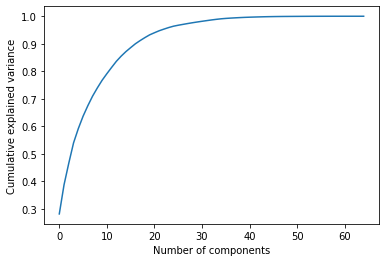

In [ ]:
pca = PCA(n_components=65)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_),)
plt.xlabel('Number of components');
plt.ylabel('Cumulative explained variance');

In [ ]:
pca = PCA(n_components=20)
X_pca= pca.fit_transform(X)
print('The dimension of the data set before using pca:',X.shape,'after using pca',X_pca.shape)

The dimension of the data set before using pca: (45016, 65) after using pca (45016, 20)


In [ ]:
pca_df = pd.DataFrame(X_pca)
pca_df['bug'] = y
PCA_labels = []
for i in range(20):
  PCA_labels.append('PC'+str(i+1))

PCA_labels.append('bug')
pca_df.columns = PCA_labels

In [ ]:
model = DBSCAN(eps = 9,metric = 'manhattan').fit(X_pca)
outliers = pca_df[model.labels_ == -1]
cluster = pca_df[model.labels_ != -1]
print("The number of outliers that has been removed ", outliers.shape[0],"which is: ", "{:.2f}".format(outliers.shape[0]/ X.shape[0] *100), "%")
print("The number of data without outliers ", cluster.shape[0],"which is: ", "{:.2f}".format(cluster.shape[0]/ X.shape[0] *100),"%")

The number of outliers that has been removed  3358 which is:  7.46 %
The number of data without outliers  41658 which is:  92.54 %


In [ ]:
cluster['outliers'] = 0
outliers['outliers'] = 1
cluster = cluster.append(outliers)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
no_outlier_df = cluster[cluster['outliers'] == 0]
no_outlier_df.drop(labels='outliers',axis =1 ,inplace = True)
no_outlier_df = no_outlier_df.sample(frac=1)
train_size = len(no_outlier_df) * 0.8
X_train_cluster = no_outlier_df.iloc[:traning_size,:-1].values
X_test_cluster = no_outlier_df.iloc[traning_size:,:-1].values

y_train_cluster = no_outlier_df.iloc[:traning_size,-1].values
y_test_cluster = no_outlier_df.iloc[traning_size:,-1].values


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
model = {
    'rf':{
    'n_estimators':[8,10,50],
    'criterion':['mse','mse','mse'],
    'max_depth':[None,None,None]
    },
}
scores_df,learning_curves = build_model(model,X_train_cluster,X_test_cluster,y_train_cluster,y_test_cluster) 

In [ ]:
model = {
    'rf':{
    'n_estimators':[5],
    'criterion':['mse'],
    'max_depth':[None]
    },
}
scores_df,learning_curves = build_model(model,X_train_cluster,X_test_cluster,y_train_cluster,y_test_cluster)

In [ ]:
scores_df

,model_name,kernel,degree,C,n_estimators,criterion,max_depth,RMSE
0,rf,NaN,NaN,NaN,5,mse,None,0.899378


In [ ]:
for i in learning_curves:
  i.show()